In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [5]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [6]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [7]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

#df.head()

In [8]:
pd.set_option('display.max_columns', None)
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,next_pymnt_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,0.0,0.0,8.0,0.0,1609.0,14.0,w,10204.87,10204.87,355.29,355.29,295.13,60.16,0.0,0.0,0.0,375.35,May-2019,0.0,1.0,Individual,0.0,178.0,38199.0,3.0,4.0,2.0,4.0,3.0,36590.0,59.0,1.0,2.0,1553.0,58.0,3700.0,1.0,0.0,4.0,6.0,4775.0,447.0,77.7,0.0,0.0,93.0,96.0,3.0,3.0,0.0,20.0,1.0,0.0,1.0,2.0,1.0,1.0,10.0,3.0,3.0,2.0,8.0,0.0,0.0,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,0.0,0.0,17.0,1.0,18368.0,34.0,w,24293.13,24293.13,873.53,873.53,706.87,166.66,0.0,0.0,0.0,929.09,May-2019,0.0,1.0,Individual,0.0,165.0,228119.0,3.0,3.0,2.0,3.0,4.0,42273.0,86.0,4.0,8.0,5197.0,61.0,50400.0,4.0,9.0,3.0,13.0,13419.0,29502.0,28.4,0.0,0.0,87.0,286.0,1.0,1.0,2.0,1.0,11.0,3.0,7.0,11.0,8.0,13.0,14.0,13.0,18.0,11.0,17.0,0.0,0.0,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,0.0,0.0,8.0,0.0,13247.0,21.0,w,19636.79,19636.79,485.44,485.44,363.21,122.23,0.0,0.0,0.0,529.88,May-2019,0.0,1.0,Individual,0.0,0.0,45684.0,2.0,3.0,2.0,3.0,4.0,32437.0,75.0,2.0,3.0,2810.0,75.0,17500.0,0.0,4.0,1.0,6.0,5711.0,2839.0,62.1,0.0,0.0,159.0,156.0,7.0,4.0,0.0,7.0,7.0,6.0,2.0,5.0,2.0,7.0,8.0,5.0,13.0,5.0,8.0,0.0,0.0,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,0.0,1.0,10.0,1.0,17996.0,23.0,w,9719.34,9719.34,335.33,335.33,280.66,54.67,0.0,0.0,0.0,353.55,May-2019,0.0,1.0,Individual,0.0,0.0,68784.0,0.0,4.0,1.0,3.0,9.0,50788.0,66.0,0.0,1.0,6360.0,69.0,23000.0,3.0,5.0,4.0,4.0,6878.0,4899.0,75.1,0.0,0.0,100.0,89.0,24.0,9.0,0.0,34.0,0.0,0.0,4.0,6.0,4.0,4.0,17.0,6.0,6.0,6.0,10.0,0.0,0.0,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,0.0,1.0,14.0,0.0,9091.0,28.0,w,21614.73,21614.73,484.36,484.36,385.27,99.09,0.0,0.0,0.0,520.39,May-2019,0.0,1.0,Individual,0.0,0.0,177745.0,0.0,1.0,0.0,2.0,14.0,16828.0,84.0,1.0,1.0,3600.0,41.0,43100.0,2.0,0.0,2.0,4.0,13673.0,19699.0,28.6,0.0,0.0,67.0,138.0,11.0,11.0,4.0,11.0,0.0,0.0,4.0,6.0,7.0,11.0,6.0,12.0,18.0,6.0,14.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [9]:
# split the target data 
y = df[target]
X = df.drop(columns=target, axis=1)
X

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,next_pymnt_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,n,27.24,0.0,0.0,8.0,0.0,1609.0,14.0,w,10204.87,10204.87,355.29,355.29,295.13,60.16,0.0,0.0,0.0,375.35,May-2019,0.0,1.0,Individual,0.0,178.0,38199.0,3.0,4.0,2.0,4.0,3.0,36590.0,59.0,1.0,2.0,1553.0,58.0,3700.0,1.0,0.0,4.0,6.0,4775.0,447.0,77.7,0.0,0.0,93.0,96.0,3.0,3.0,0.0,20.0,1.0,0.0,1.0,2.0,1.0,1.0,10.0,3.0,3.0,2.0,8.0,0.0,0.0,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,n,20.23,0.0,0.0,17.0,1.0,18368.0,34.0,w,24293.13,24293.13,873.53,873.53,706.87,166.66,0.0,0.0,0.0,929.09,May-2019,0.0,1.0,Individual,0.0,165.0,228119.0,3.0,3.0,2.0,3.0,4.0,42273.0,86.0,4.0,8.0,5197.0,61.0,50400.0,4.0,9.0,3.0,13.0,13419.0,29502.0,28.4,0.0,0.0,87.0,286.0,1.0,1.0,2.0,1.0,11.0,3.0,7.0,11.0,8.0,13.0,14.0,13.0,18.0,11.0,17.0,0.0,0.0,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,n,24.26,0.0,0.0,8.0,0.0,13247.0,21.0,w,19636.79,19636.79,485.44,485.44,363.21,122.23,0.0,0.0,0.0,529.88,May-2019,0.0,1.0,Individual,0.0,0.0,45684.0,2.0,3.0,2.0,3.0,4.0,32437.0,75.0,2.0,3.0,2810.0,75.0,17500.0,0.0,4.0,1.0,6.0,5711.0,2839.0,62.1,0.0,0.0,159.0,156.0,7.0,4.0,0.0,7.0,7.0,6.0,2.0,5.0,2.0,7.0,8.0,5.0,13.0,5.0,8.0,0.0,0.0,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,n,31.44,0.0,1.0,10.0,1.0,17996.0,23.0,w,9719.34,9719.34,335.33,335.33,280.66,54.67,0.0,0.0,0.0,353.55,May-2019,0.0,1.0,Individual,0.0,0.0,68784.0,0.0,4.0,1.0,3.0,9.0,50788.0,66.0,0.0,1.0,6360.0,69.0,23000.0,3.0,5.0,4.0,4.0,6878.0,4899.0,75.1,0.0,0.0,100.0,89.0,24.0,9.0,0.0,34.0,0.0,0.0,4.0,6.0,4.0,4.0,17.0,6.0,6.0,6.0,10.0,0.0,0.0,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,n,18.76,0.0,1.0,14.0,0.0,9091.0,28.0,w,21614.73,21614.73,484.36,484.36,385.27,99.09,0.0,0.0,0.0,520.39,May-2019,0.0,1.0,Individual,0.0,0.0,177745.0,0.0,1.0,0.0,2.0,14.0,16828.0,84.0,1.0,1.0,3600.0,41.0,43100.0,2.0,0.0,2.0,4.0,13673.0,19699.0,28.6,0.0,0.0,67.0,138.0,11.0,11.0,4.0,11.0,0.0,0.0,4.0,6.0,7.0,11.0,6.0,12.0,18.0,6.0,14.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,RENT,26000.0,Source Verified,Jan-2019,n,9.60,0.0,0.0,9.0,0.0,2684.0,20.0,w,9326.86,9326.86,1019.42,10

In [10]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [11]:
# identify non-numeric cols in our feature set to encode w/get_dummies
X.dtypes[X.dtypes != 'int64'][df.dtypes != 'float64']

home_ownership          object
verification_status     object
issue_d                 object
pymnt_plan              object
initial_list_status     object
next_pymnt_d            object
application_type        object
hardship_flag           object
debt_settlement_flag    object
dtype: object

In [12]:
# use pd.get_dummies to split each column and assign a 0/1 value 

X_encoded = pd.get_dummies(X, columns=['home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 
                                         'initial_list_status', 'next_pymnt_d', 'application_type',
                                         'hardship_flag', 'debt_settlement_flag'
                                        ])
X_encoded

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,14.0,10204.87,10204.87,355.29,355.29,295.13,60.16,0.0,0.0,0.0,375.35,0.0,1.0,0.0,178.0,38199.0,3.0,4.0,2.0,4.0,3.0,36590.0,59.0,1.0,2.0,1553.0,58.0,3700.0,1.0,0.0,4.0,6.0,4775.0,447.0,77.7,0.0,0.0,93.0,96.0,3.0,3.0,0.0,20.0,1.0,0.0,1.0,2.0,1.0,1.0,10.0,3.0,3.0,2.0,8.0,0.0,0.0,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,34.0,24293.13,24293.13,873.53,873.53,706.87,166.66,0.0,0.0,0.0,929.09,0.0,1.0,0.0,165.0,228119.0,3.0,3.0,2.0,3.0,4.0,42273.0,86.0,4.0,8.0,5197.0,61.0,50400.0,4.0,9.0,3.0,13.0,13419.0,29502.0,28.4,0.0,0.0,87.0,286.0,1.0,1.0,2.0,1.0,11.0,3.0,7.0,11.0,8.0,13.0,14.0,13.0,18.0,11.0,17.0,0.0,0.0,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,21.0,19636.79,19636.79,485.44,485.44,363.21,122.23,0.0,0.0,0.0,529.88,0.0,1.0,0.0,0.0,45684.0,2.0,3.0,2.0,3.0,4.0,32437.0,75.0,2.0,3.0,2810.0,75.0,17500.0,0.0,4.0,1.0,6.0,5711.0,2839.0,62.1,0.0,0.0,159.0,156.0,7.0,4.0,0.0,7.0,7.0,6.0,2.0,5.0,2.0,7.0,8.0,5.0,13.0,5.0,8.0,0.0,0.0,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,23.0,9719.34,9719.34,335.33,335.33,280.66,54.67,0.0,0.0,0.0,353.55,0.0,1.0,0.0,0.0,68784.0,0.0,4.0,1.0,3.0,9.0,50788.0,66.0,0.0,1.0,6360.0,69.0,23000.0,3.0,5.0,4.0,4.0,6878.0,4899.0,75.1,0.0,0.0,100.0,89.0,24.0,9.0,0.0,34.0,0.0,0.0,4.0,6.0,4.0,4.0,17.0,6.0,6.0,6.0,10.0,0.0,0.0,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,28.0,21614.73,21614.73,484.36,484.36,385.27,99.09,0.0,0.0,0.0,520.39,0.0,1.0,0.0,0.0,177745.0,0.0,1.0,0.0,2.0,14.0,16828.0,84.0,1.0,1.0,3600.0,41.0,43100.0,2.0,0.0,2.0,4.0,13673.0,19699.0,28.6,0.0,0.0,67.0,138.0,11.0,11.0,4.0,11.0,0.0,0.0,4.0,6.0,7.0,11.0,6.0,12.0,18.0,6.0,14.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [13]:
# Splitting into Train and Test sets.
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=1)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [14]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

brfc_model = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

brfc_model.fit(X_train, y_train)

y_pred = brfc_model.predict(X_test)

In [15]:
# Calculated the balanced accuracy score
accuracy_score = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy Score : {accuracy_score}")

Accuracy Score : 0.7885466545953005


In [16]:
# Display the confusion matrix
dazed_n_confused = confusion_matrix(y_test, y_pred)
dazed_n_confused

array([[   71,    30],
       [ 2153, 14951]], dtype=int64)

In [17]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.70      0.87      0.06      0.78      0.60       101
   low_risk       1.00      0.87      0.70      0.93      0.78      0.62     17104

avg / total       0.99      0.87      0.70      0.93      0.78      0.62     17205



In [18]:
acc = balanced_accuracy_score(y_test, y_pred)
print("BalancedRandomForestClassifier -- Results")
print("-------------------------------------------------")
print(f"Accuracy: {acc}")
print("----------------------------")
print("Confusion Matix")
print(confusion_matrix(y_test, y_pred))
print("----------------------------")
print("Classification Report")
print(classification_report_imbalanced(y_test, y_pred))

BalancedRandomForestClassifier -- Results
-------------------------------------------------
Accuracy: 0.7885466545953005
----------------------------
Confusion Matix
[[   71    30]
 [ 2153 14951]]
----------------------------
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.70      0.87      0.06      0.78      0.60       101
   low_risk       1.00      0.87      0.70      0.93      0.78      0.62     17104

avg / total       0.99      0.87      0.70      0.93      0.78      0.62     17205



In [20]:
# List the features sorted in descending order by feature importance
#brfc_model.feature_importances_
sorted(zip(brfc_model.feature_importances_, X.columns), reverse=True)

[(0.07876809003486353, 'initial_list_status'),
 (0.05883806887524815, 'revol_bal'),
 (0.05625613759225244, 'total_acc'),
 (0.05355513093134745, 'out_prncp'),
 (0.0500331813446525, 'total_rec_prncp'),
 (0.02966959508700077, 'int_rate'),
 (0.021129125328012987, 'debt_settlement_flag'),
 (0.01980242888931366, 'installment'),
 (0.01747062730041245, 'annual_inc'),
 (0.016858293184471483, 'pub_rec'),
 (0.01641297102011915, 'num_tl_90g_dpd_24m'),
 (0.015220714904737209, 'delinq_amnt'),
 (0.014926655663448373, 'delinq_2yrs'),
 (0.014899352873994727, 'open_il_12m'),
 (0.014881069023035237, 'open_acc'),
 (0.014859446582326507, 'acc_open_past_24mths'),
 (0.014832564501144122, 'home_ownership'),
 (0.014613819728800227, 'total_rev_hi_lim'),
 (0.014487685026878092, 'num_tl_30dpd'),
 (0.013921085423763812, 'inq_last_12m'),
 (0.013534131593418711, 'acc_now_delinq'),
 (0.013364759441576994, 'mths_since_rcnt_il'),
 (0.01332289882475225, 'max_bal_bc'),
 (0.013265926832893358, 'all_util'),
 (0.01311545089

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

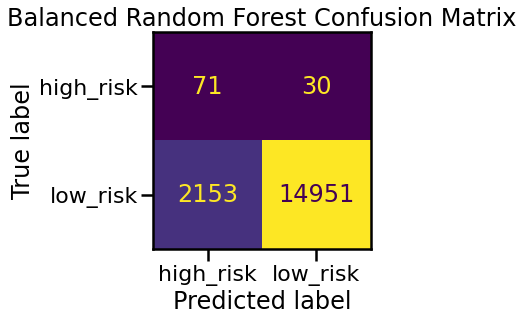

In [22]:
# took this from the imbalanced learn site.
# if I had more time I would play with it more, but too pressed for time..
#https://imbalanced-learn.org/stable/auto_examples/ensemble/plot_comparison_ensemble_classifier.html#sphx-glr-auto-examples-ensemble-plot-comparison-ensemble-classifier-py
sns.set_context("poster")

disp = plot_confusion_matrix(brfc_model, X_test, y_test, colorbar=False)
_ = disp.ax_.set_title("Balanced Random Forest Confusion Matrix")

### Easy Ensemble Classifier

In [23]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier 

eec_model = EasyEnsembleClassifier(n_estimators=100, random_state=1)

eec_model.fit(X_train, y_train)

y_pred_eec = eec_model.predict(X_test)

In [24]:
# Calculated the balanced accuracy score
accuracy_score_eec = balanced_accuracy_score(y_test, y_pred_eec)
print(f"Accuracy Score : {accuracy_score_eec}")

Accuracy Score : 0.9316600714093861


In [25]:
# Display the confusion matrix
# Display the confusion matrix
dazed_n_confused_eec = confusion_matrix(y_test, y_pred_eec)
dazed_n_confused_eec

array([[   93,     8],
       [  983, 16121]], dtype=int64)

In [26]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_eec))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.09      0.92      0.94      0.16      0.93      0.87       101
   low_risk       1.00      0.94      0.92      0.97      0.93      0.87     17104

avg / total       0.99      0.94      0.92      0.97      0.93      0.87     17205



In [27]:
acc = balanced_accuracy_score(y_test, y_pred_eec)
print("EasyEnsembleClassifier -- Results")
print("-------------------------------------------------")
print(f"Accuracy: {acc}")
print("----------------------------")
print("Confusion Matix")
print(confusion_matrix(y_test, y_pred_eec))
print("----------------------------")
print("Classification Report")
print(classification_report_imbalanced(y_test, y_pred_eec))

EasyEnsembleClassifier -- Results
-------------------------------------------------
Accuracy: 0.9316600714093861
----------------------------
Confusion Matix
[[   93     8]
 [  983 16121]]
----------------------------
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.09      0.92      0.94      0.16      0.93      0.87       101
   low_risk       1.00      0.94      0.92      0.97      0.93      0.87     17104

avg / total       0.99      0.94      0.92      0.97      0.93      0.87     17205

